In [1]:
%cd /content/drive/MyDrive/딥러닝2권/2권/05RNN

/content/drive/MyDrive/딥러닝2권/2권/05RNN


In [ ]:
# 언어모델: 단어 나열에 확률을 부여(특정 단어 시퀀스의 가능성을 확률로 평가)
# RNN: CBOW와 달리 단어의 맥락 정보를 기억

## 5.3 RNN 구현

In [8]:
import sys
sys.path.append('..')

import numpy as np
from common.np import *

In [3]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)

        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2) # tanh에 대한 역전파
        db = np.sum(dt, axis=0) # repeat에 대한 역전파
        dWh = np.matmul(h_prev.T, dt)
        dWx = np.matmul(x.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dx = np.matmul(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

### 5.3.2 Time RNN

In [4]:
# Time RNN: RNN을 동일 레이어에 T개 나열한 것
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None # T개의 RNN

        self.h, self.dh = None, None
        self.stateful = stateful

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

    def forward(self, xs): # xs는 TimeRNN에 들어오는 모든 input 배열
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape # D 입력벡터 수 , N 미니배치 크기, T RNN 개수

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]

        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:,t,:] + dh) # 이전 RNN으로부터 오는 dh를 합산
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads): # RNN은 모두 같은 가중치를 사용하고 있기에, 각 layer의 기울기 값을 모두 더해서 갱신해줘야
                grads[i] += grad

        for i, grad in enumerate(grads): # TimeRNN의 grads 값 갱신
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

## 5.4 시계열 데이터 처리 계층

In [ ]:
# TimeRNN 앞 뒤로 임베딩과 Affine, softmax 계층이 필요

In [5]:
import sys
sys.path.append('..')
from common.layers import *

class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape
        V, D = self.W.shape

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None

In [6]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

In [9]:
# Time RNN의 모든 RNN의 softmax loss를 합쳐서 갱신 진행

class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 정답 레이블이 원핫 벡터인 경우
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 배치용과 시계열용을 정리(reshape)
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # ignore_label에 해당하는 데이터는 손실을 0으로 설정
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # ignore_labelㅇㅔ 해당하는 데이터는 기울기를 0으로 설정

        dx = dx.reshape((N, T, V))

        return dx

## 5.5 RNNLM

In [10]:
class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치(Xavier 초기화)
        embed_W = (rn(V,D)/100).astype('f')
        rnn_Wx = (rn(D,H)/np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H,H)/np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H,V)/np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 가중치
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)

        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

In [ ]:
# 언어모델 평가에는 'Perplexity' 활용
# perplexity(기하평균 분기 수): 확률의 역수

### 학습

In [13]:
import matplotlib.pyplot as plt
from common.optimizer import SGD
from dataset import ptb

# hyper parameter
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN hidden state
time_size = 5
lr = 0.1
max_epoch = 100

# load data
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus = corpus[:1000] # data 1000개만
corpus_size = 1000
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1] # input
ts = corpus[1:] # answer
data_size = len(xs)

# train parameter
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 학습
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # perplexity
    ppl = np.exp(total_loss / loss_count)
    print(f'에폭: {epoch+1}, 퍼플렉시티: {ppl}')
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

에폭: 1, 퍼플렉시티: 380.01386709034546
에폭: 2, 퍼플렉시티: 251.95744133525272
에폭: 3, 퍼플렉시티: 222.21902056288886
에폭: 4, 퍼플렉시티: 217.14579105936167
에폭: 5, 퍼플렉시티: 204.924292433445
에폭: 6, 퍼플렉시티: 202.38011550125958
에폭: 7, 퍼플렉시티: 198.08234840484485
에폭: 8, 퍼플렉시티: 197.13778353375162
에폭: 9, 퍼플렉시티: 191.40355314839604
에폭: 10, 퍼플렉시티: 192.26990931818557
에폭: 11, 퍼플렉시티: 188.142893680665
에폭: 12, 퍼플렉시티: 191.81525998854093
에폭: 13, 퍼플렉시티: 189.8440151345267
에폭: 14, 퍼플렉시티: 190.66047112515557
에폭: 15, 퍼플렉시티: 189.12931094875682
에폭: 16, 퍼플렉시티: 186.1310296113258
에폭: 17, 퍼플렉시티: 184.9729873917661
에폭: 18, 퍼플렉시티: 180.53482633435058
에폭: 19, 퍼플렉시티: 181.7730738456678
에폭: 20, 퍼플렉시티: 183.09726079145787
에폭: 21, 퍼플렉시티: 180.55091764930523
에폭: 22, 퍼플렉시티: 177.19303245780247
에폭: 23, 퍼플렉시티: 175.29164452017017
에폭: 24, 퍼플렉시티: 175.70789927717874
에폭: 25, 퍼플렉시티: 173.253870703535
에폭: 26, 퍼플렉시티: 171.91192148366574
에폭: 27, 퍼플렉시티: 167.99310253729263
에폭: 28, 퍼플렉시티: 165.97713265408876
에폭: 29, 퍼플렉시티: 163.08167727489425
에폭: 30, 퍼플렉시티: 159.6873776742679


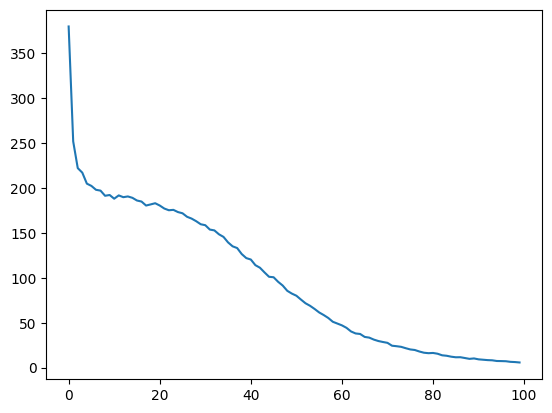

In [16]:
plt.plot(ppl_list)